In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data

We need 1D gaussian samples as the "real" cohort, and the noise fed to the generator will be n-dim uniform samples.

In [33]:
def generate_gaussian(n_samples, n_dim):
    return np.random.randn(n_samples, n_dim)

def generate_uniform(n_samples, n_dim):
    return np.random.rand(n_samples, n_dim)

# Model

Generator and Discriminator models, to be used in GAN

In [34]:
class Generator(nn.Module):
    
    def __init__(self, in_feat: int, out_feat: int):
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_feat, out_feat)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        return x

In [35]:
class Discriminator(nn.Module):
    
    def __init__(self, in_feat: int):
        super().__init__()
        self.fc = nn.Linear(in_feat, 1)
        
    def forward(self, x):
        x = F.sigmoid(self.fc(x))
        return x

# Train

In [36]:
# data
N = 10

# models
generator = Generator(in_feat=N, out_feat=1)
discriminator = Discriminator(in_feat=1)

# optimizers
optimizer_gen = SGD(params=generator.parameters(), lr=0.01)
optimizer_disc = Adam(params=discriminator.parameters(), lr=0.01)

# criterion
criterion = nn.BCELoss()

In [69]:
def train(epochs=10):
    
    BATCH_SZ = 128
    
    loss_D = []
    loss_G = []
    
    for _ in tqdm(range(epochs)):
        discriminator.zero_grad()
        
        # sample minibatch of noise and real
        noise = torch.tensor(generate_uniform(BATCH_SZ, N), dtype=torch.float32)
        real = torch.tensor(generate_gaussian(BATCH_SZ, 1), dtype=torch.float32)
        
        # get X and y
        created = generator(noise)
        x = torch.concat([real, created.detach()])
        y = torch.concat([torch.ones((BATCH_SZ,1)), torch.zeros((BATCH_SZ,1))])
        
        # update discriminator
        out1 = discriminator(x)
        loss_1 = criterion(out1, y)
        loss_1.backward()
        optimizer_disc.step()
        
        loss_D.append(loss_1.item)
        
        # update generator
        discriminator.zero_grad()
        
        out2 = discriminator(created)
        loss_2 = criterion(out2, torch.zeros((BATCH_SZ, 1)))
        loss_2.backward()
        optimizer_gen.step()
        
        loss_G.append(loss_2.item)
        
    return loss_D, loss_G
    

In [70]:
loss_D, loss_G = train(100)

100%|██████████| 100/100 [00:00<00:00, 3305.33it/s]


# Evaluate

This is just a qualitative evaluation, make sure the generator builds a Gaussian distribution.

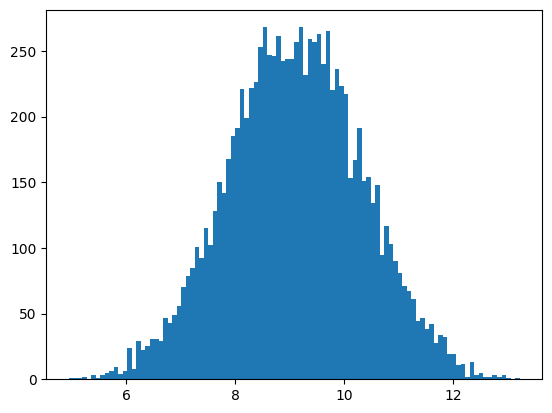

In [71]:
# evaluate
with torch.no_grad():
    noise = torch.tensor(np.random.rand(10000, N)).to(torch.float32)
    generated_samples = generator(noise).detach()

plt.hist(generated_samples, bins=100)
plt.show()
